In [1]:
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import wcs
from astropy.coordinates import SkyCoord

In [3]:
from scipy.interpolate import Rbf

# Initialize data directory

In [4]:
path = "../../Data/Subaru_data/"

# Dust data

```
!open $path
```

In [5]:
dust = fits.open(path + "p358Dust.fits")

In [6]:
w = wcs.WCS(dust[0].header)

In [7]:
dust[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                   82                                                  
NAXIS2  =                   82                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'mag E(B-V)'                                                          
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =           273.000000                                                  
CRVAL2  =            40.0000

In [8]:
pix_coords = np.array([[i, j] for i in range(dust[0].data.shape[0])
              for j in range(dust[0].data.shape[1])])

In [9]:
wcs_coords = w.wcs_pix2world(pix_coords, 1)

In [10]:
wcs_x = np.array(wcs_coords.transpose()[0])
wcs_y = np.array(wcs_coords.transpose()[1])

In [11]:
dust[0].data.shape

(82, 82)

In [12]:
wcs_x_grid = wcs_x.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))
wcs_y_grid = wcs_y.reshape((dust[0].data.shape[0], dust[0].data.shape[1]))

# basic dust properties

In [13]:
np.mean(dust[0].data.ravel())

0.036121546490218627

In [14]:
np.std(dust[0].data.ravel())

0.0085454334243817032

## convert pixel to WCS so we can apply correction to data catalog

<matplotlib.colorbar.Colorbar instance at 0x1162e73b0>

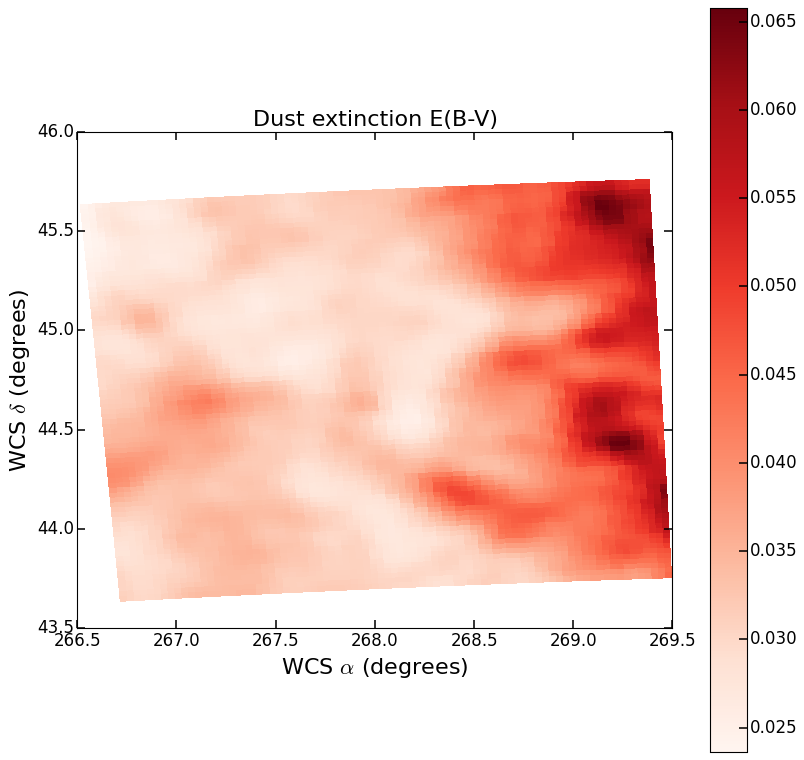

In [15]:
plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()



* checked the features of the above image with DS9
* ready to do dust extinction correction

\begin{equation}
E(B-V) \equiv A_B - A_V = (B-V)_{observed} - (B-V)_{intrinsic}
\end{equation}

Therefore, to correct for dust extinction in the (B-V) band, we have ...

\begin{equation}
(B-V)_{intrinsic} = (B - V)_{observed} - E(B-V)
\end{equation}

for each WCS pixel ... easy enough!
Reference: [http://en.wikipedia.org/wiki/Extinction_(astronomy)]('http://en.wikipedia.org/wiki/Extinction_(astronomy)')

### examine how the dust map compared to the coordinates in the shape catalog

In [16]:
shape_h5file = "../../Data/Subaru_data/combined_cat.h5"
shape_df_key = "preprocess_df"


In [48]:
Rshapes = pd.read_hdf(shape_h5file, shape_df_key)

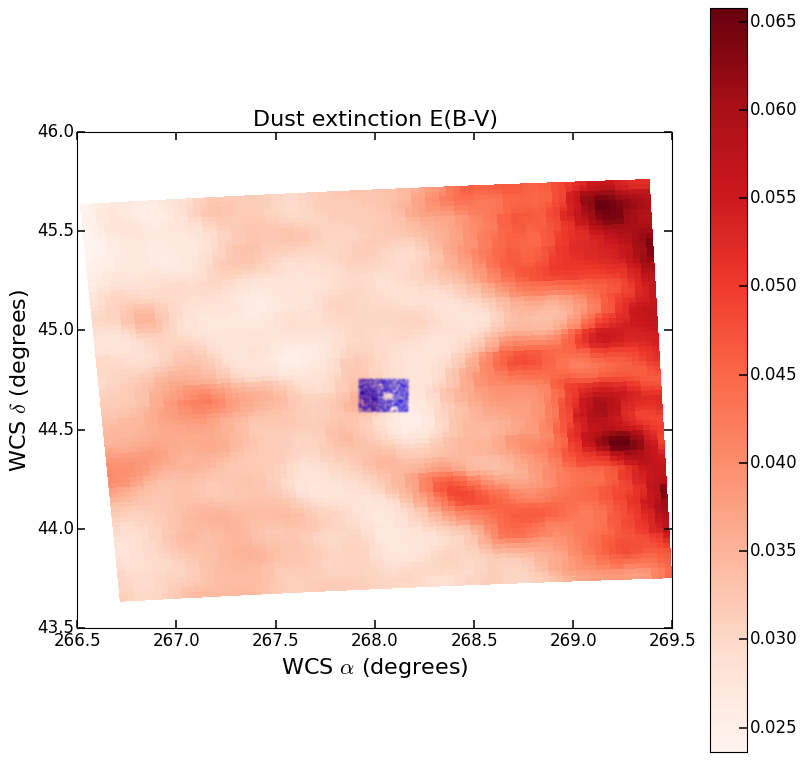

In [18]:

plt.figure(figsize=(12, 12))
plt.axes().set_aspect("equal")
plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)
plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()

plt.plot(Rshapes.RA, Rshapes.DEC, '.', alpha=0.01)

# do interpolation

so our transformed dust data is actually diagonal so there are no longer just 81 x 81 grid in wcs coordinates... it's better for us to switch every thing to pixel coordinates then do interpolation

In [19]:
Rshapes_pix_coords = \
    w.wcs_world2pix(np.array([Rshapes.RA, Rshapes.DEC]).transpose(), 1)

In [20]:
XX, YY = np.meshgrid(range(dust[0].data.shape[0]),
                     range(dust[0].data.shape[0]))

In [21]:
rbf = Rbf(XX, YY, dust[0].data, epsilon=2)

In [22]:
dust_ext = rbf(list(Rshapes_pix_coords.transpose()[0]),
               list(Rshapes_pix_coords.transpose()[1]))

In [23]:
dust_ext.shape

(8892,)

<matplotlib.colorbar.Colorbar instance at 0x12e1fc200>

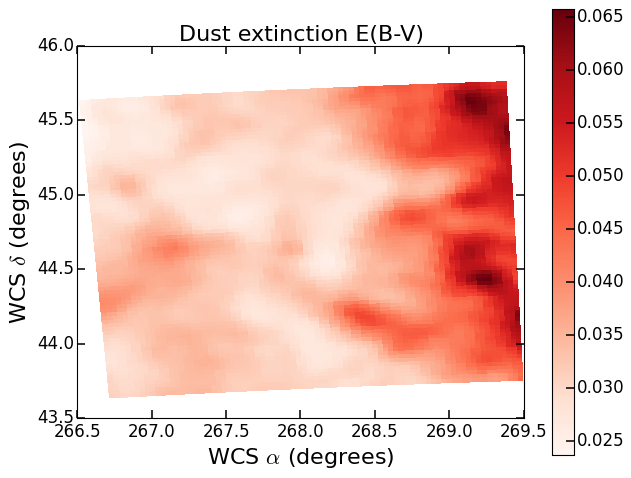

In [25]:
plt.axes().set_aspect("equal")


plt.pcolor(wcs_x_grid, wcs_y_grid, dust[0].data.transpose(), 
           cmap=plt.cm.Reds)

plt.title("Dust extinction E(B-V)", size=20)
plt.ylabel(r"WCS $\delta$ (degrees)", size=20)
plt.xlabel(r"WCS $\alpha$ (degrees)", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.colorbar()

In [49]:
Rshapes["E(B-V)"] = dust_ext

# stop being lazy and just cut out relevant region

# verifying that I did the interpolation correctly

recalculate where to cut ... ref: van Weeren 2012 Fig. 1

In [29]:
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")
ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

267.916666667 268.166666667
44.5916666667 44.7583333333


In [30]:
ra_mask = np.logical_and(wcs_x < ra_upper + 0.1,
                         wcs_x > ra_lower - 0.1)
dec_mask = np.logical_and(wcs_y < dec_upper + 0.1,
                          wcs_y > dec_lower - 0.1)
mask = np.logical_and(ra_mask, dec_mask)

In [31]:
ix = np.arange(len(wcs_x))[mask]

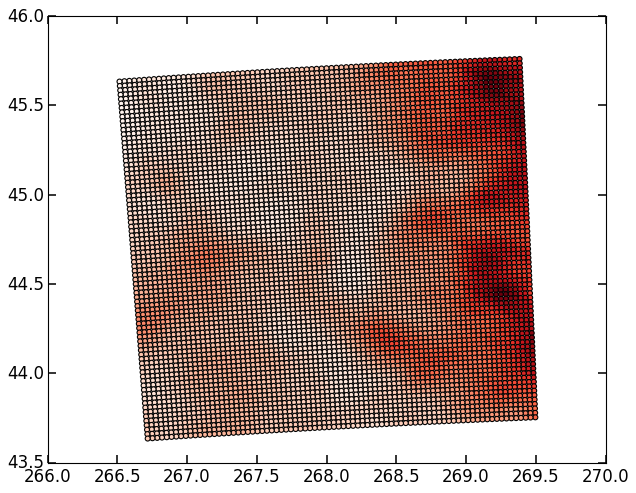

In [32]:
plt.scatter(wcs_x, wcs_y, c=dust[0].data.transpose().ravel(),
            cmap=plt.cm.Reds)

<matplotlib.colorbar.Colorbar instance at 0x12feee8c0>

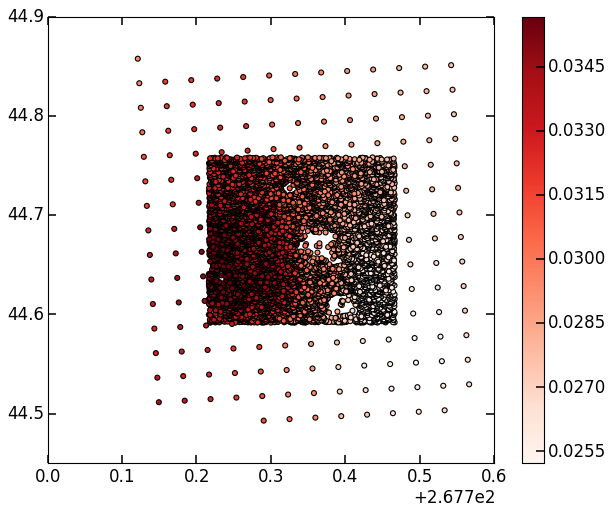

In [33]:
plt.scatter(Rshapes.RA, Rshapes.DEC, c=dust_ext,
            cmap=plt.cm.Reds)
plt.scatter(wcs_x[ix], wcs_y[ix], 
            c=dust[0].data.transpose().ravel()[ix],
            cmap=plt.cm.Reds)
plt.colorbar()

# do actual correction

In [50]:
from preprocess_data import Schlafly_dereddening

In [51]:
for k in ["I", "G", "R"]:
    for bandtype in ["ISO", "AUTO", "APER"]:
        key = "{0}band_MAG_{1}".format(k, bandtype)
        Rshapes[key] = \
            Rshapes.apply(lambda x: Schlafly_dereddening(x[key], 
                                   x["E(B-V)"], 
                                   band_name="{}".format(k.lower())), 
                                   axis=1)

In [52]:
keys = ["{}band_MAG_ISO".format(k) for k in ["I", "G", "R"]]

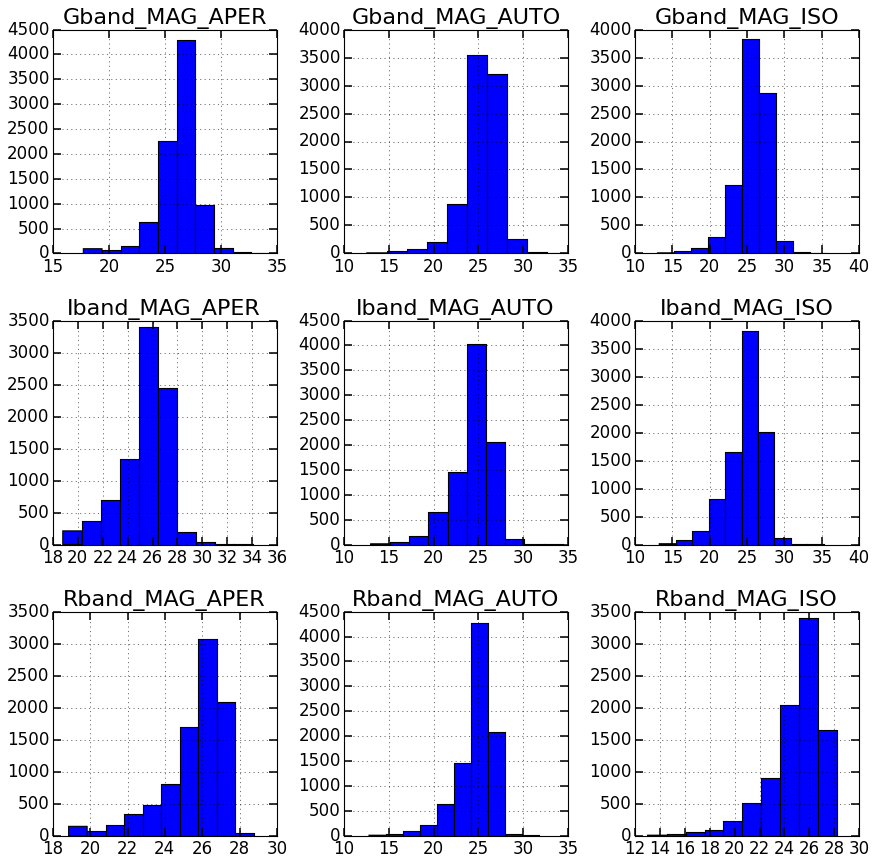

In [56]:
bands = [k for k in Rshapes.keys() if "_MAG_" in k]
_ = Rshapes[bands].hist(figsize=(13, 13))

In [57]:
Rshapes[bands].describe()

,Rband_MAG_ISO,Rband_MAG_APER,Rband_MAG_AUTO,Iband_MAG_ISO,Iband_MAG_APER,Iband_MAG_AUTO,Gband_MAG_ISO,Gband_MAG_APER,Gband_MAG_AUTO
count,8892.000000,8890.000000,8805.000000,8725.000000,8707.000000,8593.000000,8618.000000,8629.000000,8277.000000
mean,25.001536,25.584348,24.713841,24.837088,25.352129,24.453186,25.731850,26.214474,25.380188
std,2.086500,1.687954,1.943242,2.344023,1.924824,2.147174,2.106427,1.770950,1.986817
min,13.004297,18.835820,12.784573,13.233079,18.783519,12.964162,12.993135,17.707679,12.529636
25%,24.129535,24.977689,23.997376,23.704050,24.513616,23.505133,24.787088,25.527085,24.587621
50%,25.518529,26.092309,25.205514,25.304609,25.831011,24.908473,26.032235,26.485812,25.666323
75%,26.478144,26.753624,26.018493,26.442154,26.611417,25.861015,27.059859,27.232185,26.544761
max,28.254106,28.765305,31.742564,35.287410,34.064882,34.426799,35.696868,34.389143,34.884982


In [58]:
Rshapes.to_hdf(shape_h5file, shape_df_key)